In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from power import power_dim
from mgc.independence import *
from mgc.sims import *

sys.path.append(os.path.realpath('..'))

/home/sampan501/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import seaborn as sns
sns.color_palette('Set1')
sns.set(color_codes=True, style='white', context='talk', font_scale=2, palette="colorblind")

In [3]:
POWER_REPS = 5

In [4]:
simulations = [
    linear,
    exponential,
    cubic,
    joint_normal,
    step,
    quadratic,
    w_shaped,
    spiral,
    uncorrelated_bernoulli,
    logarithmic,
    fourth_root,
    sin_four_pi,
    sin_sixteen_pi,
    square,
    two_parabolas,
    circle,
    ellipse,
    diamond,
    multiplicative_noise,
    multimodal_independence
]

tests = [
#      CCA,
#      Dcorr,
#      HHG,
     Hsic,
#      RV
]

In [5]:
def find_dim(sim):
    if sim not in simulations:
        raise ValueError("Invalid simulation")
        
    if sim in [joint_normal, sin_four_pi, sin_sixteen_pi, multiplicative_noise]:
        dim = 10
    elif sim in [multimodal_independence, uncorrelated_bernoulli, logarithmic]:
        dim = 100
    elif sim in [linear, exponential, cubic]:
        dim = 1000
    elif sim in [square, diamond]:
        dim = 40
    else:
        dim = 20
        
    return dim

def find_dim_range(dim):
    if dim < 20:
        lim = 10
    else:
        lim = 20
    
    dim_range = list(range(int(dim/lim), dim+1, int(dim/lim)))
    if int(dim/lim) != 1:
        dim_range.insert(0, 1)
        lim = len(dim_range)
    return lim, dim_range

In [6]:
def estimate_power(sim, test):
    dim = find_dim(sim)
    lim, dim_range = find_dim_range(dim)
    est_power = np.array([np.mean([power_dim(test, sim, p=dim_range[i]) for _ in range(POWER_REPS)])
                          for i in tqdm(range(lim))])
    np.savetxt('../benchmarks/vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [7]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:  4.7min remaining: 42.1min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  5.6min remaining: 32.0min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  5.8min remaining: 23.1min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed: 15.9min remaining: 47.7min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed: 16.6min remaining: 38.7min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed: 17.8min remaining: 33.1min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 17.8min remaining: 26.8min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed: 18.4min remaining: 22.5min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed: 18.5min remaining: 18.5min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 23.3min remaining: 19.1min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapse

In [8]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = simulations[count]
            
            for test in tests:
                power = np.genfromtxt('../benchmarks/vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
                                      delimiter=',')
                _, dim_range = find_dim_range(find_dim(sim))
                
                custom_color = {
                    "Dcorr" : "b",
                    "Hsic" : "g"
                }
                if test.__name__ in custom_color.keys():
                    if test.__name__ not in ["MGC", "MGCRF"]:
                        col.plot(dim_range, power, custom_color[test.__name__], label=test.__name__, lw=5)
                    else:
                        col.plot(dim_range, power, custom_color[test.__name__], label=test.__name__, lw=2)
                else:
                    col.plot(dim_range, power, label=test.__name__, lw=1)
                col.set_xticks([dim_range[0], dim_range[-1]])
                col.set_ylim(0, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.08, 'Dimensions', ha='center')
    fig.text(0.08, 0.5, 'Absolute Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)

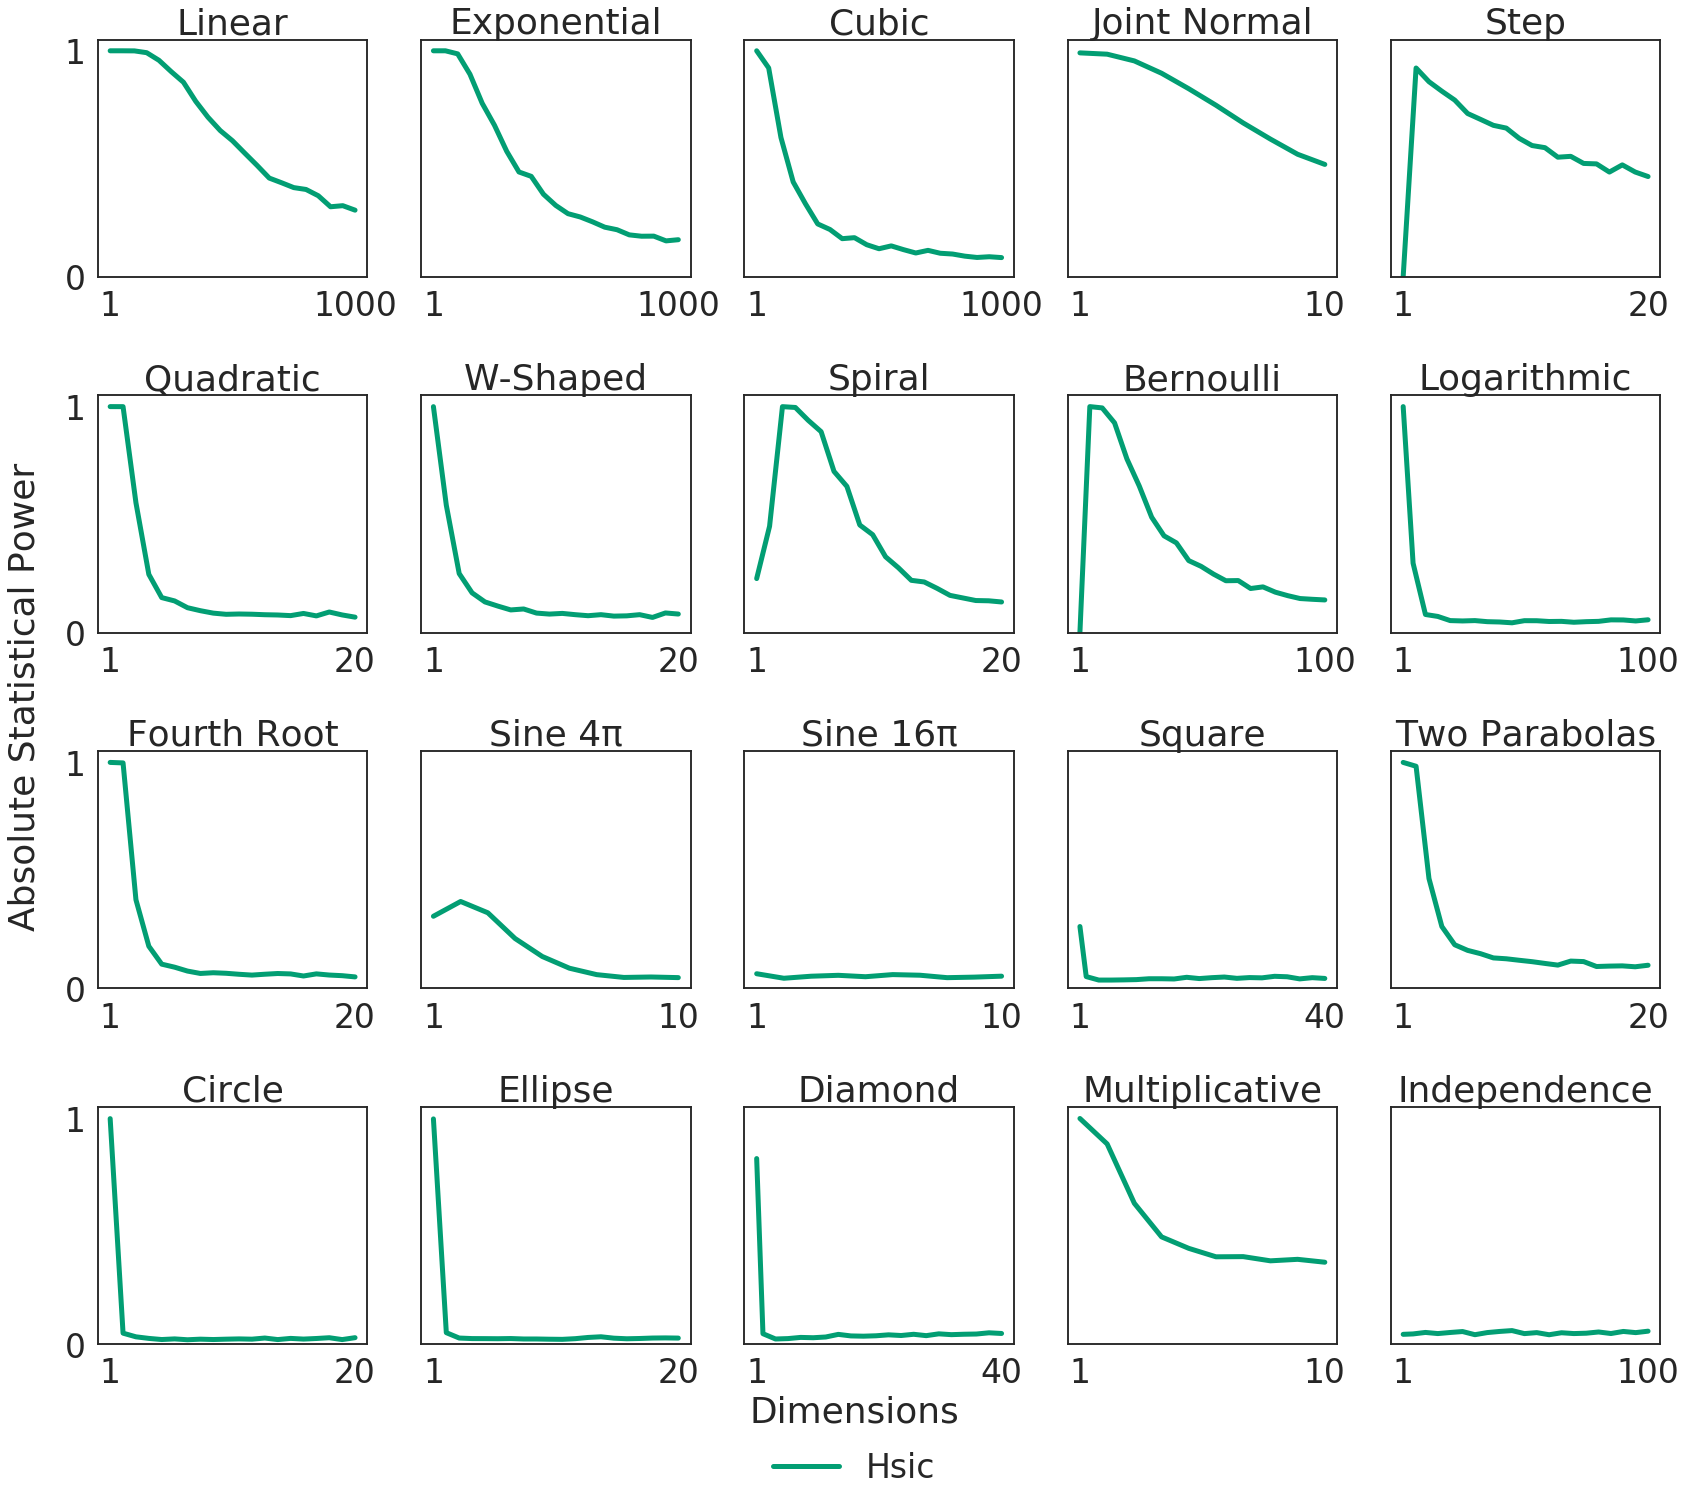

In [9]:
plot_power()